## Analysis of motor synergies, Todorov's paper (panel A)

In [1]:
from definitions import ROOT_DIR
import os
from stable_baselines3.common.vec_env import VecNormalize
from sb3_contrib import RecurrentPPO
from envs.environment_factory import EnvironmentFactory
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle
from functions_notebook import PCvsVar,plot_cumvar,make_parallel_envs

/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MyoSuite:> Registering Myo Envs


### A. Control task : hand pose lattice

1. Load the hand's positions and velocities 

In [2]:
# Load the file from Basecamp : 'rollouts_hand_pose_lattice.h5'
fp = os.path.join(ROOT_DIR,'rollouts_hand_pose_lattice.h5')
observations = pd.read_hdf(fp).to_dict(orient='dict')['observation']
hand_positions = np.array([observations[ep][0:23] for ep in observations.keys()])
hand_velocities = np.array([observations[ep][23:46] for ep in observations.keys()])

2. Compute the PCs

In [4]:
n = 23

# Absolute joint angles
abs_pos_var = PCvsVar(df=hand_positions, n_comp=n)
print('Abs, position\n',np.cumsum(abs_pos_var))

# Normalized to range (0,1)
norm01_hand_positions = np.array([(hand_pos-np.min(hand_pos))/(np.max(hand_pos)-np.min(hand_pos)) for hand_pos in hand_positions.T]).T
norm01_pos_var = PCvsVar(df=norm01_hand_positions, n_comp=n)
print('0-1 range, position \n',np.cumsum(norm01_pos_var))

# Normalized to unit variance
scaler = StandardScaler(with_mean=False)
norm_hand_positions = np.array([np.squeeze(scaler.fit_transform(np.reshape(hand_pos,(hand_positions.shape[0],1)))) for hand_pos in hand_positions.T]).T
norm_pos_var = PCvsVar(df=norm_hand_positions, n_comp=n)
print('Unit variance, position \n',np.cumsum(norm_pos_var))

# Absolute joint velocities
abs_vel_var = PCvsVar(df=hand_velocities, n_comp=n)
print('Abs, velocity\n',np.cumsum(abs_vel_var))

# Normalized to range (0,1)
norm01_hand_velocities = np.array([(hand_vel-np.min(hand_vel))/(np.max(hand_vel)-np.min(hand_vel)) for hand_vel in hand_velocities.T]).T
norm01_vel_var = PCvsVar(df=norm01_hand_velocities, n_comp=n)
print('0-1 range, velocity\n',np.cumsum(norm01_vel_var))

# Normalized to unit variance
scaler = StandardScaler(with_mean=False)
norm_hand_velocities = np.array([np.squeeze(scaler.fit_transform(np.reshape(hand_vel,(hand_velocities.shape[0],1)))) for hand_vel in hand_velocities.T]).T
norm_vel_var = PCvsVar(df=norm_hand_velocities, n_comp=n)
print('Unit variance, velocity\n',np.cumsum(norm_vel_var))


Abs, position
 [0.53182467 0.62648169 0.70549848 0.78195845 0.83992109 0.88385773
 0.91369338 0.94010378 0.95461661 0.96557062 0.97347554 0.97910968
 0.98342417 0.98682088 0.98997979 0.99258762 0.9945543  0.99616286
 0.99734813 0.99843528 0.99924383 0.99976342 1.        ]
0-1 range, position 
 [0.47284579 0.56144521 0.64857087 0.71353537 0.7641684  0.80830254
 0.84535055 0.87831605 0.9051243  0.92454948 0.93953549 0.95288332
 0.96358317 0.9730533  0.97973442 0.98461487 0.98881707 0.99191708
 0.99477922 0.99693525 0.99850975 0.99949987 1.        ]
Unit variance, position 
 [0.43200544 0.54512779 0.62716861 0.69698226 0.74695013 0.78846409
 0.82359324 0.85640702 0.88384959 0.90594315 0.92485541 0.94174638
 0.95529909 0.96690621 0.97523582 0.98342862 0.98849616 0.9926583
 0.99550719 0.99763652 0.99880817 0.99962537 1.        ]
Abs, velocity
 [0.44970134 0.62982406 0.78757048 0.88049495 0.92218171 0.94647289
 0.96065508 0.97061358 0.97828099 0.98413906 0.98957991 0.99247107
 0.99467216 0.9

3. Plot the explained variance vs. number of PCs for each 3 pre-processing methods

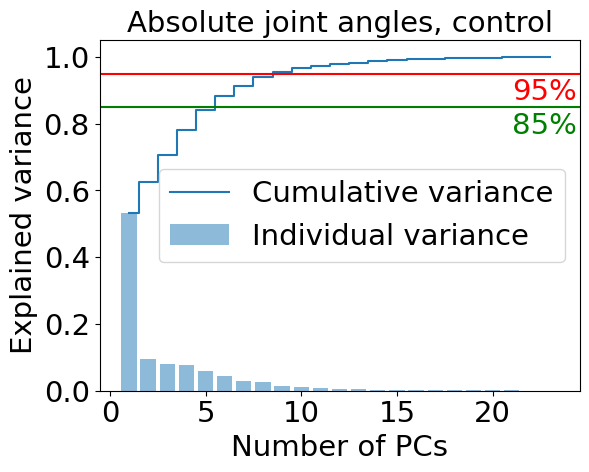

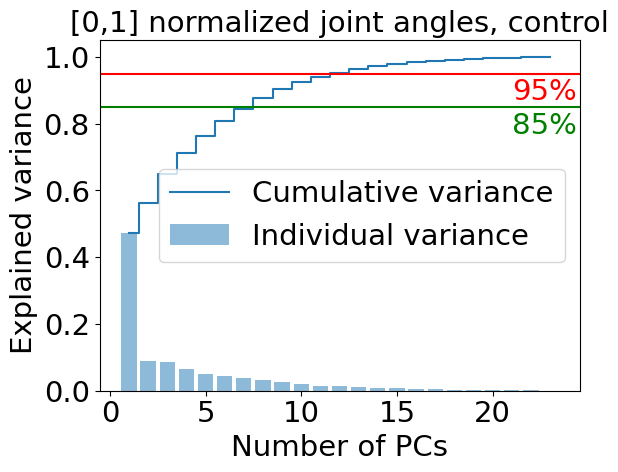

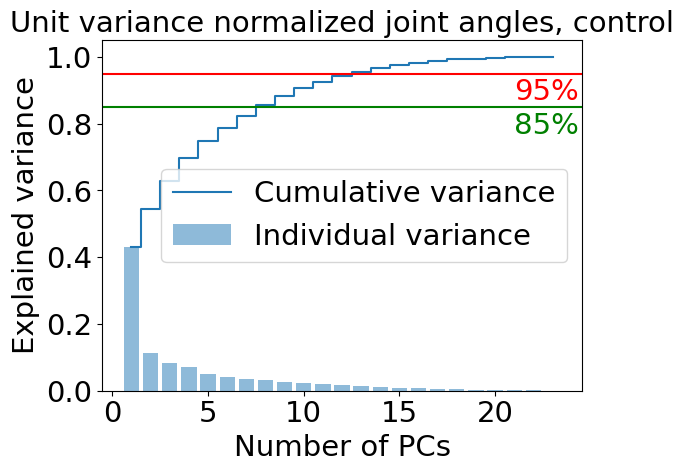

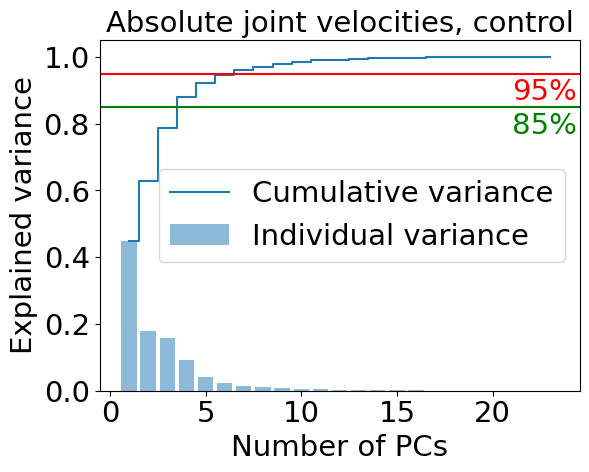

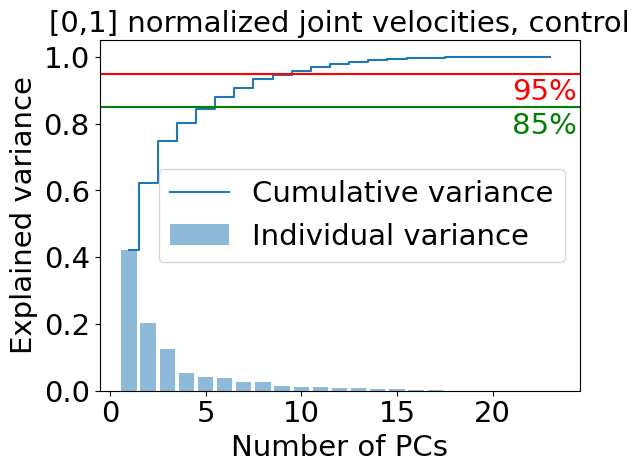

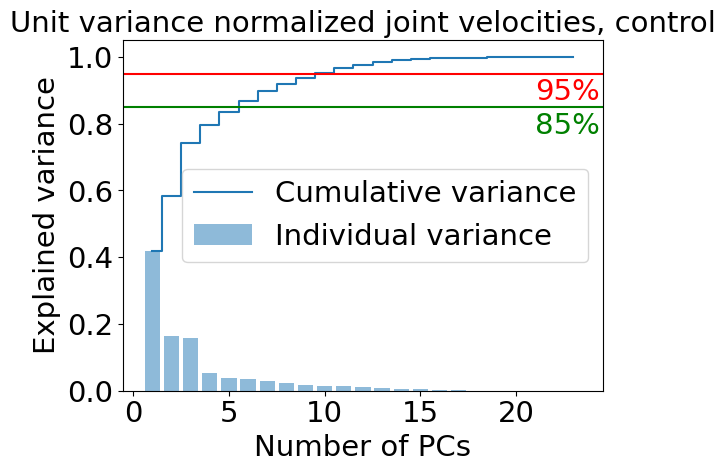

In [5]:
# Position space
plot_cumvar(n_comp=n,exp_var_ratio=abs_pos_var,title='Absolute joint angles, control')
plot_cumvar(n_comp=n,exp_var_ratio=norm01_pos_var,title='[0,1] normalized joint angles, control')
plot_cumvar(n_comp=n,exp_var_ratio=norm_pos_var,title='Unit variance normalized joint angles, control')

# Velocity space
plot_cumvar(n_comp=n,exp_var_ratio=abs_vel_var,title='Absolute joint velocities, control')
plot_cumvar(n_comp=n,exp_var_ratio=norm01_vel_var,title='[0,1] normalized joint velocities, control')
plot_cumvar(n_comp=n,exp_var_ratio=norm_vel_var,title='Unit variance normalized joint velocities, control')

### B. Manipulation task : baoding balls

1. Generate and save the hand's positions and velocities. __Go to 2. to directly load the previously-obtained data.__

In [7]:
env_name = 'CustomMyoBaodingBallsP2' 
render = False

PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

config = {
    "weighted_reward_keys": {
        "pos_dist_1": 0,
        "pos_dist_2": 0,
        "act_reg": 0,
        "alive": 0,
        "solved": 5,
        "done": 0,
        "sparse": 0
    },
    "enable_rsi": False,
    "rsi_probability": 0,
    "balls_overlap": False,
    "overlap_probability": 0,
    "noise_fingers": 0,
    "limit_init_angle": 3.141592653589793,
    "goal_time_period": [
        5,
        5
    ],
    "goal_xrange": [
        0.02,
        0.03
    ],
    "goal_yrange": [
        0.022,
        0.032
    ],
    "obj_size_range": [
        0.018,
        0.024
    ],
    "obj_mass_range": [
        0.03,
        0.3
    ],
    "obj_friction_change": [
        0.2,
        0.001,
        2e-05
    ],
    "task_choice": "fixed",
    "rotation_direction" : "cw"
}

envs = make_parallel_envs(env_name, config, num_env=1)
envs = VecNormalize.load(PATH_TO_NORMALIZED_ENV, envs)
envs.training = False
envs.norm_reward = False
custom_objects = {
    "learning_rate": lambda _: 0,
    "lr_schedule": lambda _: 0,
    "clip_range": lambda _: 0,
}
model = RecurrentPPO.load(
        PATH_TO_PRETRAINED_NET, env=envs, device="cpu", custom_objects=custom_objects
    )

eval_model = model
eval_env = EnvironmentFactory.create(env_name,**config)

num_ep = 25
tot_pos = []
tot_vel = []

for n in range(num_ep):
    obs_tot = []
    cum_reward = 0
    lstm_states = None
    obs = eval_env.reset()
    episode_starts = np.ones((1,), dtype=bool)
    done = False
    timestep = 0
    while not done: 
        if render :
            eval_env.sim.render(mode="window")
            
        timestep += 1
        action, lstm_states = eval_model.predict(envs.normalize_obs(obs),
                                                state=lstm_states,
                                                episode_start=episode_starts,
                                                deterministic=True,
                                                )
                                                    
        obs, rewards, done, info = eval_env.step(action)
        episode_starts = done
        cum_reward += rewards
        obs_tot.append(obs)
    print(cum_reward)

    # MEASURE JOINT POSITION AND VELOCITY
    hand_positions = np.array(obs_tot)[:,0:23]    
    hand_velocities = np.array([np.diff(pos)/0.0025 for pos in hand_positions.T]).T
    hand_velocities = np.vstack((np.zeros((1,23)),hand_velocities))
    tot_pos.append(hand_positions)
    tot_vel.append(hand_velocities)
    
tot_pos = np.concatenate(tot_pos,axis=0)
tot_vel = np.concatenate(tot_vel,axis=0)

'''fp = ""
fp_posvel = open(fp, 'wb')
pickle.dump([tot_pos,tot_vel],fp_posvel)
fp_posvel.close()'''

MyoSuite:> Registering Myo Envs


/home/ingster/anaconda3/envs/MyoChallenge2/lib/python3.8/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object _last_lstm_states. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


925.0
745.0
915.0
610.0
830.0
290.0
395.0
760.0
705.0
820.0
765.0
190.0
790.0
975.0
885.0
765.0
730.0
865.0
860.0
945.0
740.0
895.0
870.0
845.0
795.0


'fp = ""\nfp_posvel = open(fp, \'wb\')\npickle.dump([tot_pos,tot_vel],fp_posvel)\nfp_posvel.close()'

2. Load the hand's positions and velocities

In [8]:
# # Load the file from basecamp : 'posvel_synergies'
l = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/posvel_synergies','rb'))
hand_positions = l[0]
hand_velocities = l[1]

3. Compute the PCs

In [9]:
n = 23

# Absolute joint angles
abs_pos_var = PCvsVar(df=hand_positions, n_comp=n)
print('Abs, position\n',np.cumsum(abs_pos_var))

# Normalized to range (0,1)
norm01_hand_positions = np.array([(hand_pos-np.min(hand_pos))/(np.max(hand_pos)-np.min(hand_pos)) for hand_pos in hand_positions.T]).T
norm01_pos_var = PCvsVar(df=norm01_hand_positions, n_comp=n)
print('0-1 range, position \n',np.cumsum(norm01_pos_var))

# Normalized to unit variance
scaler = StandardScaler(with_mean=False)
norm_hand_positions = np.array([np.squeeze(scaler.fit_transform(np.reshape(hand_pos,(hand_positions.shape[0],1)))) for hand_pos in hand_positions.T]).T
norm_pos_var = PCvsVar(df=norm_hand_positions, n_comp=n)
print('Unit variance, position \n',np.cumsum(norm_pos_var))

# Absolute joint velocities
abs_vel_var = PCvsVar(df=hand_velocities, n_comp=n)
print('Abs, velocity\n',np.cumsum(abs_vel_var))

# Normalized to range (0,1)
norm01_hand_velocities = np.array([(hand_vel-np.min(hand_vel))/(np.max(hand_vel)-np.min(hand_vel)) for hand_vel in hand_velocities.T]).T
norm01_vel_var = PCvsVar(df=norm01_hand_velocities, n_comp=n)
print('0-1 range, velocity\n',np.cumsum(norm01_vel_var))

# Normalized to unit variance
scaler = StandardScaler(with_mean=False)
norm_hand_velocities = np.array([np.squeeze(scaler.fit_transform(np.reshape(hand_vel,(hand_velocities.shape[0],1)))) for hand_vel in hand_velocities.T]).T
norm_vel_var = PCvsVar(df=norm_hand_velocities, n_comp=n)
print('Unit variance, velocity\n',np.cumsum(norm_vel_var))

Abs, position
 [0.4024 0.6459 0.8213 0.9192 0.9438 0.9624 0.9732 0.9799 0.9858 0.9901
 0.9937 0.9965 0.9983 0.9994 0.9998 0.9999 0.9999 1.     1.     1.
 1.     1.     1.    ]
0-1 range, position 
 [0.2599 0.4747 0.6557 0.7918 0.8353 0.8646 0.8886 0.9106 0.9253 0.9389
 0.9505 0.9608 0.9686 0.9758 0.9813 0.9862 0.9902 0.9936 0.9965 0.9986
 0.9993 0.9998 1.    ]
Unit variance, position 
 [0.2874 0.4736 0.6334 0.7204 0.7756 0.8139 0.8463 0.8717 0.8941 0.913
 0.9294 0.9437 0.9537 0.9631 0.97   0.9762 0.9819 0.9872 0.9916 0.9948
 0.9977 0.9996 1.    ]
Abs, velocity
 [0.3376 0.5882 0.7418 0.798  0.8445 0.8743 0.9012 0.9221 0.9407 0.9556
 0.9672 0.9766 0.9846 0.9898 0.9942 0.997  0.998  0.9989 0.9994 0.9996
 0.9998 1.     1.    ]
0-1 range, velocity
 [0.2882 0.4534 0.5832 0.6504 0.698  0.7436 0.7778 0.8104 0.839  0.865
 0.8861 0.9056 0.9223 0.9384 0.9524 0.9638 0.9734 0.9814 0.9885 0.9934
 0.9978 0.9989 1.    ]
Unit variance, velocity
 [0.197  0.3126 0.4144 0.4971 0.5652 0.6304 0.6837 0.7337 

3. Plot the explained variance vs. number of PCs for each 3 pre-processing methods.

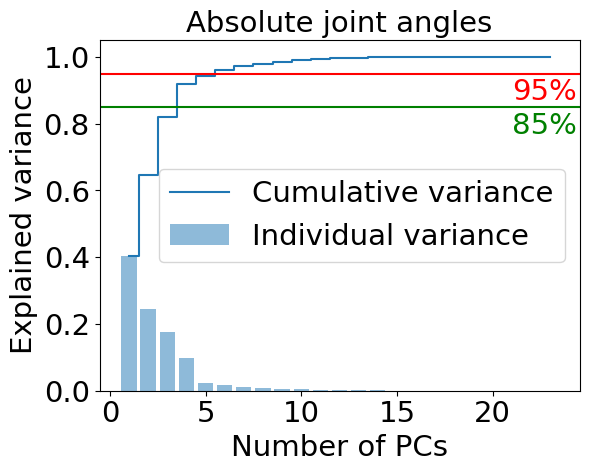

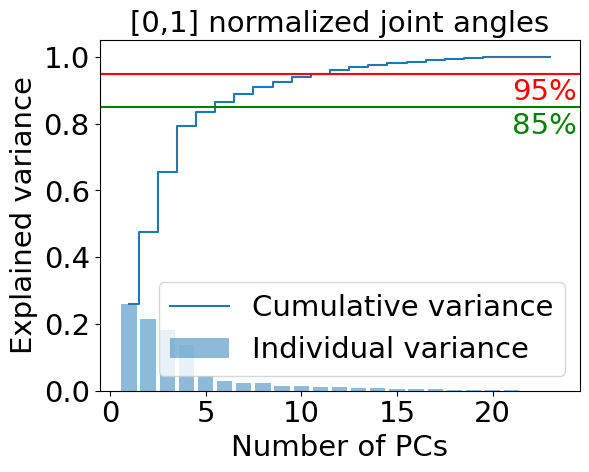

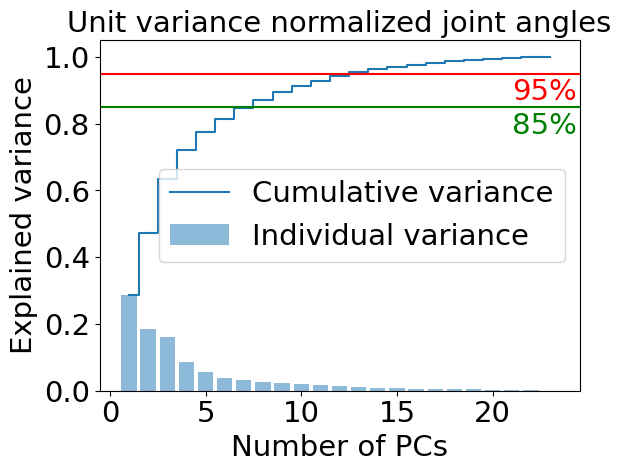

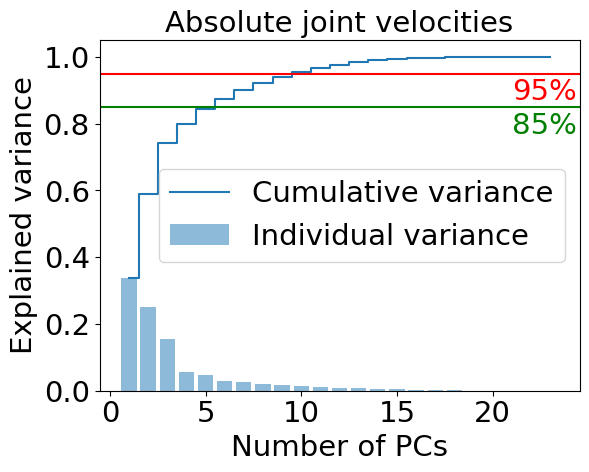

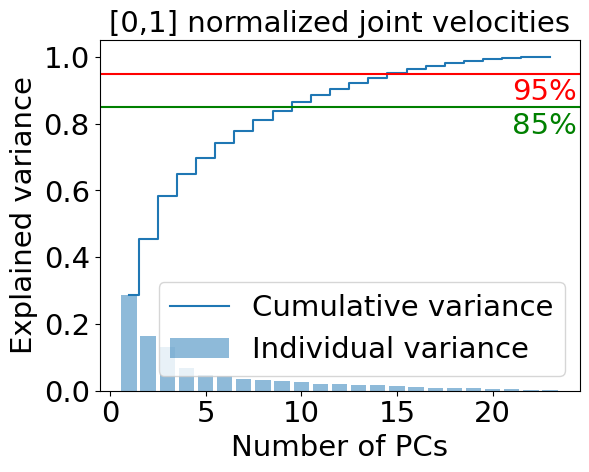

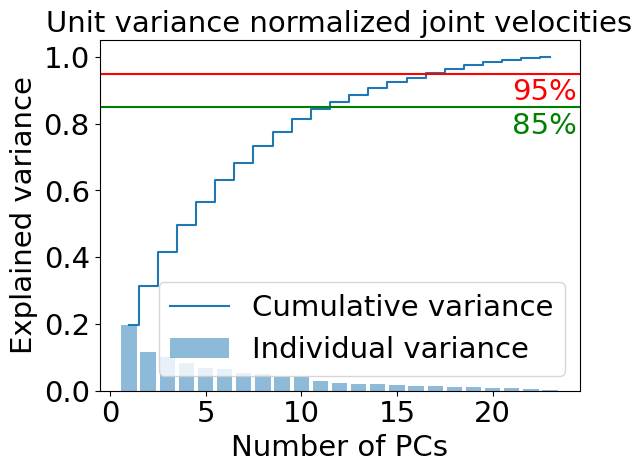

In [10]:
# Position space
plot_cumvar(n_comp=n,exp_var_ratio=abs_pos_var,title='Absolute joint angles')
plot_cumvar(n_comp=n,exp_var_ratio=norm01_pos_var,title='[0,1] normalized joint angles')
plot_cumvar(n_comp=n,exp_var_ratio=norm_pos_var,title='Unit variance normalized joint angles')

# Velocity space
plot_cumvar(n_comp=n,exp_var_ratio=abs_vel_var,title='Absolute joint velocities')
plot_cumvar(n_comp=n,exp_var_ratio=norm01_vel_var,title='[0,1] normalized joint velocities')
plot_cumvar(n_comp=n,exp_var_ratio=norm_vel_var,title='Unit variance normalized joint velocities')